In [1]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from sklearn.model_selection import train_test_split

from utils import *

In [2]:
class AutoencoderDatasetTest(Dataset):
    '''Class defining the dataset for the autoencoder'''

    def __init__(self, data, device='cpu', color='gray', transform=None, transform_noise=None):
        '''
        Constructor for the AutoencoderDataset class

        Args:
            data: the data to be used for the dataset
            device: the device to load the data on
            color: define the color type of the images
            transform: the transformations to be applied to the images
        '''
        self.data = data
        self.transform = transform
        self.device = device
        self.color = color
        self.transform_noise = transform_noise

    def __len__(self):
        '''Returns the length of the dataset'''
        return len(self.data)

    def __getitem__(self, index):
        '''
        Returns the item at the given index

        Args:
            index: the index of the item to be returned

        Returns:
            x, x: the image at the given index as the input and the target
        '''
        x = Image.open(self.data[index])

        if self.color == 'color':
            if x.mode != 'RGB':
                x = x.convert('RGB')
        elif self.color == 'gray':
            x = x.convert('L')
        else:
            raise ValueError('Invalid color type. Please use either "color" or "gray"')

        if self.transform:
            x = self.transform(x)

        if self.transform_noise:
            new_x = self.transform_noise(x)
            return new_x.to(self.device), x.to(self.device)

        return x.to(self.device), x.to(self.device)

In [3]:
def loadData(data_dir, batch_size, test_size=0.2, color='gray'):
    '''
    Loads the data from the given directory and returns the train and test loaders

    Args:
        data_dir: the directory containing the data
        batch_size: the batch size for the data loaders
        test_size: the proportion of the data to be assigned to the test set
        color: the color type of the images
    
    Returns:
        train_loader: the data loader for the training set
        test_loader: the data loader for the test set
    '''
    gaussian_noise = transforms.Lambda(lambda x: addGaussianNoiseTensor(x, mean = 0.1, std = 0.01))
    sap_noise = transforms.Lambda(lambda x: addSaltPepperNoiseTensor(x, salt_prob = 0.08, pepper_prob = 0.08))
    poisson_noise = transforms.Lambda(lambda x: addPoissonNoiseTensor(x, intensity=0.1))
    speckle_noise = transforms.Lambda(lambda x: addSpeckleNoiseTensor(x, scale=0.4))

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.456], std=[0.229]),
    ])

    transform_noise = transforms.Compose([transforms.RandomApply([gaussian_noise, sap_noise, poisson_noise], p = 0.5)])

    data = []
    for image_name in os.listdir(data_dir):
        image_path = os.path.join(data_dir, image_name)
        data.append(image_path)

    data_train, data_test = train_test_split(data, test_size=test_size, random_state=42)

    device = getDevice()
    train_dataset = AutoencoderDatasetTest(data_train, device=device, color=color, transform=transform, transform_noise=transform_noise)
    test_dataset = AutoencoderDatasetTest(data_test, device=device, color=color, transform=transform, transform_noise=transform_noise)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)

    return train_loader, test_loader

def getDevice():
    '''Returns the device to be used in case of availability of the GPU'''
    return torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

def showImages(dataloader, num_images=5):
    '''
    Displays a grid of sample images from the given data loader

    Args:
        dataloader: the data loader to display the images from
        num_images: the number of images to display

    Returns:
        None
    '''
    data_iter = iter(dataloader)
    images, _ = next(data_iter)

    plt.figure(figsize=(15, 5))
    plt.axis("off")
    plt.title("Sample Images from DataLoader")
    plt.imshow(np.transpose(vutils.make_grid(images[:num_images], padding=5, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

data read


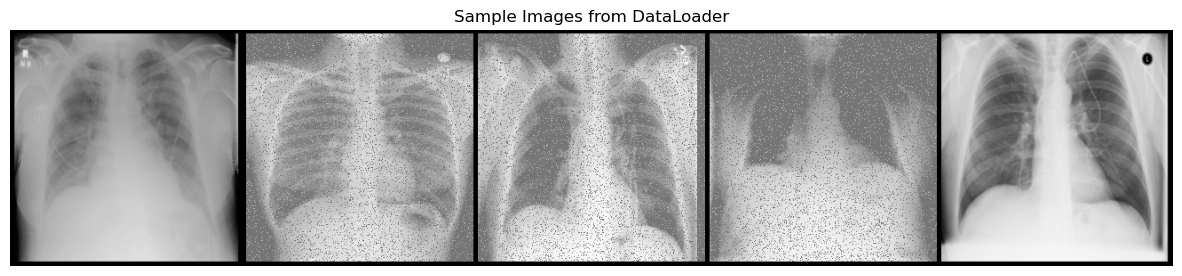

In [5]:
data_dir = 'data/'
batch_size = 64
train_loader, test_loader = loadData(data_dir, batch_size, color='gray')
print('data read')
showImages(train_loader, 5)